In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import string
import numpy as np
import random
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

In [16]:
orig_solutions = pd.read_csv('mystery_words.csv', header=None)[0].to_list()
orig_solutions = list(map(lambda x: x.upper(), orig_solutions))
solutions = list(map(lambda x: list(x), orig_solutions))
orig_herrings = pd.read_csv('guessable_words.csv', header=None)[0].to_list()
orig_herrings = list(map(lambda x: x.upper(), orig_herrings))
herrings = list(map(lambda x: list(x), orig_herrings))

In [17]:
def process_guess(herring, solution):
    score = []
    for i, letter in enumerate(herring):
        # right letter, right place
        if herring[i] == solution[i]:
            score.append(2)
        # right letter, wrong place
        elif letter in solution:
            score.append(1)
        # wrong letter, wrong place
        else:
            score.append(0)
    return score

def simulate_guess_for_all_solutions(herring, solution_pool):
    heuristics = {'correct': [], 'present': [], 'absent': [], 'tile_score': []}
    for solution in solution_pool:
        score = process_guess(herring, solution)
        heuristics['correct'].append(score.count(2))
        heuristics['present'].append(score.count(1))
        heuristics['absent'].append(score.count(0))
        heuristics['tile_score'].append(sum(score))
    avg_heuristics = {k: np.mean(v) for k, v in heuristics.items()}
    return avg_heuristics.values()
        
herring_df =  pd.DataFrame(orig_herrings, columns=['herring'])
herring_df['avg_correct'], herring_df['avg_present'], herring_df['avg_absent'], herring_df['avg_tile_score'] = zip(*herring_df['herring'].progress_apply(lambda x: simulate_guess_for_all_solutions(x, orig_solutions)))
orig_herring_df = herring_df
orig_herring_df

100%|██████████| 12972/12972 [02:19<00:00, 92.85it/s] 


,herring,avg_correct,avg_present,avg_absent,avg_tile_score
0,AAHED,0.384449,1.180562,3.434989,1.949460
1,AALII,0.313607,1.310583,3.375810,1.937797
2,AARGH,0.355508,1.084665,3.559827,1.795680
3,AARTI,0.327430,1.387041,3.285529,2.041901
4,ABACA,0.293737,1.193089,3.513175,1.780562
...,...,...,...,...,...
12967,ZUZIM,0.172786,0.463067,4.364147,0.808639
12968,ZYGAL,0.177970,0.819438,4.002592,1.175378
12969,ZYGON,0.153348,0.699784,4.146868,1.006479
12970,ZYMES,0.190497,0.856587,3.952916,1.237581


In [18]:
orig_herring_df.sort_values(by='avg_tile_score', ascending=False)

,herring,avg_correct,avg_present,avg_absent,avg_tile_score
9558,SAREE,0.680346,1.253132,3.066523,2.613823
8908,RAREE,0.567603,1.460475,2.971922,2.595680
9722,SEARE,0.644060,1.289417,3.066523,2.577538
502,AREAE,0.506263,1.552916,2.940821,2.565443
514,ARERE,0.501512,1.526566,2.971922,2.529590
...,...,...,...,...,...
12967,ZUZIM,0.172786,0.463067,4.364147,0.808639
4147,FUZZY,0.309719,0.187473,4.502808,0.806911
8739,PZAZZ,0.205184,0.382289,4.412527,0.792657
5981,KUDZU,0.130454,0.526566,4.342981,0.787473


--------------
Guess #1
SAREE (guess) | REEDY (solution)
--------------
Guess #2
DREER (guess) | REEDY (solution)
--------------
Guess #3
DREED (guess) | REEDY (solution)
--------------
Guess #4
CREED (guess) | REEDY (solution)
--------------
Guess #5
BREED (guess) | REEDY (solution)
--------------
Guess #6
FREED (guess) | REEDY (solution)
--------------
Guess #7
GREED (guess) | REEDY (solution)
--------------
Guess #8
REEDE (guess) | REEDY (solution)
--------------
Guess #9
REEDY (guess) | REEDY (solution)
YAY


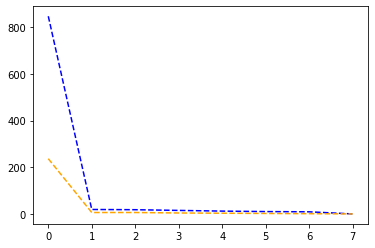

In [19]:
def filter_list(pool, guess, score):
    for i, char in enumerate(guess):
        if score[i] == 2:
            pool = [word for word in pool if word[i] == char]
        elif score[i] == 1:
            pool = [word for word in pool if char in word]
        else:
            pool = [word for word in pool if char not in word]
    return pool

def simulate_round(guess, solution, herring_df, solution_pool):
    score = process_guess(guess, solution)
    print(f"{guess} (guess) | {solution} (solution)")
    if guess == solution:
        return True
    solution_pool = filter_list(solution_pool, guess, score)
    herring_pool = filter_list(list(herring_df['herring']), guess, score)
    if guess in herring_pool: herring_pool.remove(guess)
    new_herring_df = herring_df.copy()
    new_herring_df = new_herring_df[new_herring_df.herring.isin(herring_pool)]
    
    # re-run simulation to get new heuristic scoring metrics
    new_herring_df['avg_correct'], new_herring_df['avg_present'], new_herring_df['avg_absent'], new_herring_df['avg_tile_score'] = zip(*new_herring_df['herring'].map(lambda x: simulate_guess_for_all_solutions(x, solution_pool)))
    return solution_pool, new_herring_df
    
def run_simulation(solution):
    global orig_solutions, orig_herring_df
    solution_pool = orig_solutions
    herring_df = orig_herring_df
    count = 1
    s_pool_size, h_pool_size = [], []
    solved = False
    while not solved:
        print("--------------")
        print(f"Guess #{count}")
        guess = herring_df.sort_values(by='avg_tile_score', ascending=False).iloc[0, 0]
        simu_results = simulate_round(guess, solution, herring_df, solution_pool)
        if simu_results == True:
            solved = True
            print("YAY")
        else:
            solution_pool, herring_df = simu_results
            s_pool_size.append(len(solution_pool))
            h_pool_size.append(len(herring_df))
            # print(f"herring pool size {len(herring_df)}")
            # print(f"solution pool size {len(solution_pool)}")
        count += 1
    fig = plt.figure()
    plt.plot(list(range(count-2)), h_pool_size, color='blue', linestyle='--')
    plt.plot(list(range(count-2)), s_pool_size, color='orange', linestyle='--')
    
solution = random.choice(orig_solutions)
run_simulation(solution)

In [20]:
def compute_avg_pool_size_shrink(herring, herring_pool, solution_pool):
    h_pool_shrink, s_pool_shrink = [], []
    for solution in solution_pool:
        score = process_guess(herring, solution)
        new_solution_pool = filter_list(solution_pool, herring, score)
        new_herring_pool = filter_list(herring_pool, herring, score)
        if herring in new_herring_pool: new_herring_pool.remove(herring)
        h_pool_shrink.append((len(herring_pool) - len(new_herring_pool)) / len(herring_pool))
        s_pool_shrink.append((len(solution_pool) - len(new_solution_pool)) / len(solution_pool))
    return np.mean(h_pool_shrink), np.mean(s_pool_shrink)

# herring_df2 = pd.DataFrame(orig_herrings, columns=['herring'])
# herring_df2['herring_pool_shrink'], herring_df2['solution_pool_shrink'] = zip(*herring_df2['herring'].progress_apply(lambda x: compute_avg_pool_size_shrink(x, list(herring_df2['herring']), orig_solutions)))
herring_shrinkage_df = pd.read_csv('herring_pool_shrinkage_experiment.csv')
orig_herring_df = orig_herring_df.merge(herring_shrinkage_df, how='inner', on='herring')
orig_herring_df

,herring,avg_correct,avg_present,avg_absent,avg_tile_score,herring_pool_shrink,solution_pool_shrink
0,AAHED,0.384449,1.180562,3.434989,1.949460,0.889388,0.892491
1,AALII,0.313607,1.310583,3.375810,1.937797,0.837520,0.842616
2,AARGH,0.355508,1.084665,3.559827,1.795680,0.862285,0.873473
3,AARTI,0.327430,1.387041,3.285529,2.041901,0.913571,0.920445
4,ABACA,0.293737,1.193089,3.513175,1.780562,0.752848,0.755081
...,...,...,...,...,...,...,...
12967,ZUZIM,0.172786,0.463067,4.364147,0.808639,0.719876,0.716516
12968,ZYGAL,0.177970,0.819438,4.002592,1.175378,0.842319,0.846841
12969,ZYGON,0.153348,0.699784,4.146868,1.006479,0.806110,0.810507
12970,ZYMES,0.190497,0.856587,3.952916,1.237581,0.880027,0.860814


In [21]:
orig_herring_df.to_csv('./all_herrings_all_heuristics.csv', index=False)

In [71]:
from tqdm import tqdm

def simulate_round(guess, solution, herring_df, solution_pool):
    score = process_guess(guess, solution)
    # colored_guess = "".join([f"[{color_map[num]}]{char}[/{color_map[num]}]" for num, char in zip(score, guess)])
    # print(f"{guess} (guess) | {solution} (solution)")
    if guess == solution:
        return True
    solution_pool = filter_list(solution_pool, guess, score)
    herring_pool = filter_list(list(herring_df['herring']), guess, score)
    if guess in herring_pool: herring_pool.remove(guess)
    new_herring_df = herring_df.copy()
    new_herring_df = new_herring_df[new_herring_df.herring.isin(herring_pool)]
    # re-run simulation to get new heuristic scoring metrics
    new_herring_df['greens'], new_herring_df['yellows'], new_herring_df['sum'] = zip(*new_herring_df['herring'].map(lambda x: simulate_guess_for_all_solutions(x, solution_pool)))
    return solution_pool, new_herring_df

def get_num_guesses(guess, solution):
    global orig_solutions, orig_herring_df
    solution_pool = orig_solutions
    herring_df = orig_herring_df
    count = 1
    simu_results = simulate_round(guess, solution, herring_df, solution_pool)
    while True:
        if simu_results == True:
            return count
        else:
            solution_pool, herring_df = simu_results
            guess = herring_df.sort_values(by='sum', ascending=False).iloc[0, 0]
            simu_results = simulate_round(guess, solution, herring_df, solution_pool)
            count += 1
            
def get_avg_guess_count(solution):
    top_guesses = herring_shrinkage_df.reset_index(drop=True).iloc[:10]
    return np.mean([get_num_guesses(guess, solution) for guess in top_guesses['herring']])
        
solution_df =  pd.DataFrame(orig_solutions, columns=['solution'])
solution_df['avg_num_guesses'] = solution_df['solution'].progress_apply(get_avg_guess_count)

100%|██████████| 2315/2315 [1:23:58<00:00,  2.18s/it]


In [74]:
solution_df.sort_values(by='avg_num_guesses', ascending=True)

,solution,avg_num_guesses
109,ARRAY,2.5
1760,SISSY,2.6
1543,RARER,2.6
1689,SENSE,2.7
1638,SALSA,2.8
...,...,...
2232,WATCH,9.8
2189,VAUNT,9.9
1106,LAYER,10.0
2173,USAGE,10.1
